In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import Counter

In [2]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Meilleurs coefficients pour la classification binaire")
    plt.savefig('img/coefs_linear_svm.png')
    plt.show()

In [126]:
def canonizer(data, test_size=0.1, random_state=42, sampling=None, cross_validation=False, cv=5, kernel='rbf', nb_coef=20):
    
    df_results = pd.DataFrame()
    
    if cross_validation == True:
        
        pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
        
        cv_results = cross_val_score(pipe, data.drop(['gender'], axis=1), data['gender'], cv=cv, scoring=make_scorer(classification_report_with_accuracy_score))
        return pipe, cv_results
    
    else:
        if kernel == 'rbf':
            pipe = make_pipeline(StandardScaler(), Normalizer(), SVC(kernel=kernel, probability=True))
        else:
            pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
    

        X_train, X_test, y_train, y_test = train_test_split(data.drop(['gender'], axis=1), data['gender'], test_size=test_size, random_state=random_state)
        print('Original dataset shape {}'.format(Counter(y_train)))
        
        pipe.fit(X_train, y_train)
        
        report = metrics.classification_report(y_test, pipe.predict(X_test), output_dict=True)
        df_scores = pd.DataFrame(report).transpose()
        print(df_scores)

        _ = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
                   
        df_results['metadata'] = y_test
        df_results['proba male'] = pipe.predict_proba(X_test)[:,0]
        df_results['proba female'] = pipe.predict_proba(X_test)[:,1]
        df_results['prediction']= pipe.predict(X_test)
        
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
    
        if kernel == 'linear':
            coefs = pipe.named_steps['svc'].coef_
            plot_coefficients(*coefs, data.columns, nb_coef)
            coef_names = data.columns
            return pipe, df_results, df_scores, coefs, coef_names

    return pipe, df_results, df_scores

In [65]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [84]:
df_main = pd.read_csv(r'/home/crazyjeannot/Downloads/features_gendered.csv')
df_main.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_main.set_index("id", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [85]:
df_main = df_main[(df_main.Gender == 'female') | (df_main.Gender == 'Female') | (df_main.Gender == 'male') | (df_main.Gender == 'Male')]
df_main['Gender'] = ['Female' if (elem == 'female') | (elem == 'Female') else 'Male' for elem in df_main['Gender']]

In [86]:
df_main.Gender.value_counts(normalize=True)

Male      0.561667
Female    0.438333
Name: Gender, dtype: float64

In [87]:
df_main

,faire,lui,avoir,vouloir,bien,eÌter,voir,savoir,c,le,...,arrieÌre,droÌle,accueillir,resteÌ,tristesse,excuse,creÌature,deÌsirer,expression,Gender
id,,,,,,,,,,,,,,,,,,,,,
ta sur-96,0.003924,0.004484,0.001121,0.001121,0.007848,0.0,0.005605,0.000000,0.003924,0.003363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Female
ma femme-1313,0.002567,0.003851,0.000642,0.000000,0.001284,0.0,0.006418,0.000000,0.000642,0.005777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Female
L' ambulancière-1146,0.004695,0.005477,0.004695,0.001565,0.000000,0.0,0.009390,0.000000,0.001565,0.008607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Female
Cornaboeux-262,0.002366,0.005521,0.001577,0.006309,0.001577,0.0,0.003155,0.000000,0.000000,0.000789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Male
le Danois-1114,0.002632,0.001754,0.002632,0.002632,0.005263,0.0,0.000000,0.000000,0.000000,0.007018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mademoiselle Saget-5381,0.005117,0.008772,0.002924,0.001462,0.005117,0.0,0.002924,0.009503,0.002193,0.005848,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Female
C'-23,0.000709,0.012057,0.005674,0.002128,0.004255,0.0,0.002837,0.005674,0.003546,0.003546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Male
La petite Pauline-4534,0.005166,0.002952,0.001476,0.004428,0.000000,0.0,0.002952,0.004428,0.002952,0.004428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Female


Original dataset shape Counter({'Male': 306, 'Female': 234})
              precision    recall  f1-score  support
Female         0.428571  0.103448  0.166667     29.0
Male           0.509434  0.870968  0.642857     31.0
accuracy       0.500000  0.500000  0.500000      0.5
macro avg      0.469003  0.487208  0.404762     60.0
weighted avg   0.470350  0.500000  0.412698     60.0


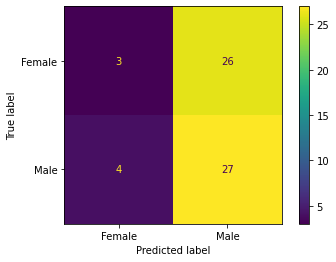

In [88]:
pipe, results, scores = canonizer(df_main)

In [134]:
def ratio_truncate_df(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = round(df_res['gender'].value_counts(normalize=True)[1],2)
    index_noncanon = df_res[df_res['gender']  == 'Male'].index 
    i, j = 0, 20
        
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=20

        ratio_temp = round(df_res['gender'].value_counts(normalize=True)[1],2)

    return shuffle(df_res)

In [90]:
df_sizeopti_gendered = ratio_truncate_df(df_main, 0.49)

In [91]:
df_sizeopti_gendered['Gender'].value_counts(normalize=True)

Male      0.512963
Female    0.487037
Name: Gender, dtype: float64

Original dataset shape Counter({'Male': 251, 'Female': 235})
              precision    recall  f1-score    support
Female         0.629630  0.607143  0.618182  28.000000
Male           0.592593  0.615385  0.603774  26.000000
accuracy       0.611111  0.611111  0.611111   0.611111
macro avg      0.611111  0.611264  0.610978  54.000000
weighted avg   0.611797  0.611111  0.611245  54.000000


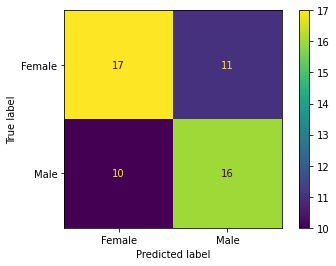

In [92]:
pipe, results, scores = canonizer(df_sizeopti_gendered)

In [158]:
df_doc2vec

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,gender
index,,,,,,,,,,,,,,,,,,,,,
Balzac-Honore-de_Modeste-Mignon_<un valet vêtu comme un banquier-3064>,-0.937789,1.847197,1.629252,0.683998,-1.126932,-1.845310,-3.167574,-1.115496,-0.055344,-0.497644,...,1.672632,-2.680111,-1.784738,-4.033972,0.025602,-0.145136,2.807801,0.897232,1.609842,Male
Balzac-Honore-de_Modeste-Mignon_<le duc d' Hérouville-5358>,-2.323091,3.374835,1.255428,1.840915,0.750646,-3.770832,-3.532389,0.744216,2.005828,-0.990992,...,0.460937,-0.286300,-0.672060,-1.797982,-1.782469,-0.015236,2.409774,-0.459937,2.203179,Male
Balzac-Honore-de_Modeste-Mignon_<Canalis-5111>,-2.196753,4.127802,-1.609070,0.398565,0.364477,-2.122252,-1.096556,1.440241,0.916868,-3.063825,...,0.636439,0.138064,-0.827780,-2.624165,-0.595635,-0.124855,1.990690,-1.755381,0.816353,Male
Balzac-Honore-de_Modeste-Mignon_<Canalis et les deux nobles filles-4893>,0.040619,1.637769,0.932671,0.964462,0.531388,-2.519024,-1.137877,0.093011,0.321003,-0.741512,...,1.423507,-1.297616,-2.609149,-2.211704,-0.918111,1.388330,1.041664,0.341126,2.601527,Male
Balzac-Honore-de_Modeste-Mignon_<le petit Dumay-4143>,-1.281073,3.158107,-0.330044,0.582367,-0.319029,-1.249777,-3.170653,0.658690,-1.368025,-0.913827,...,1.132821,-0.770731,0.225303,-2.584770,-1.413867,0.777204,2.060883,-1.128845,0.077148,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gouraud-Julie_Chez-grand-mere_<cette charmante artiste-2660>,-0.022521,0.978605,1.403170,-0.322144,2.384720,-0.420093,-3.625079,0.351910,0.402099,-1.839371,...,1.574940,0.208136,-0.490952,-0.084764,0.011217,-0.310226,0.842179,0.565950,-0.961076,Female
Gouraud-Julie_Chez-grand-mere_<Mme d' Hyver-1784>,-0.575108,1.034587,-0.184628,-1.599928,0.868005,-0.919833,-3.411946,-1.120972,0.246425,-0.219164,...,1.162513,0.478964,-0.349855,-0.470144,0.403505,-0.573963,1.441820,1.037831,0.919870,Female
Gouraud-Julie_Chez-grand-mere_<qui-769>,-0.968423,0.471641,0.877110,0.954226,-0.035572,-1.014387,-3.215647,-0.838491,0.643441,-2.058778,...,1.380471,-0.584621,0.165089,-0.716386,-0.521991,-0.602847,1.702764,-0.197713,0.777583,Male


In [128]:
df_doc2vec = pd.read_csv(r'training_set/data_gendered_doc2vec_bigger.csv')

In [129]:
df_doc2vec.set_index("index", inplace = True)
#df_main = df_main.replace(np.nan, 0)

In [130]:
df_doc2vec['gender'].value_counts(normalize=True)

Male      0.54902
Female    0.45098
Name: gender, dtype: float64

Original dataset shape Counter({'Male': 404, 'Female': 330})
              precision    recall  f1-score    support
Female         0.704545  0.815789  0.756098  38.000000
Male           0.815789  0.704545  0.756098  44.000000
accuracy       0.756098  0.756098  0.756098   0.756098
macro avg      0.760167  0.760167  0.756098  82.000000
weighted avg   0.764237  0.756098  0.756098  82.000000


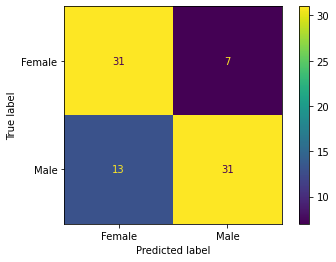

In [132]:
pipe, results, scores = canonizer(df_doc2vec)

In [137]:
df_sizeopti_gendered = ratio_truncate_df(df_doc2vec, 0.47)

Original dataset shape Counter({'Male': 366, 'Female': 332})
              precision    recall  f1-score    support
Female         0.857143  0.833333  0.845070  36.000000
Male           0.860465  0.880952  0.870588  42.000000
accuracy       0.858974  0.858974  0.858974   0.858974
macro avg      0.858804  0.857143  0.857829  78.000000
weighted avg   0.858932  0.858974  0.858811  78.000000


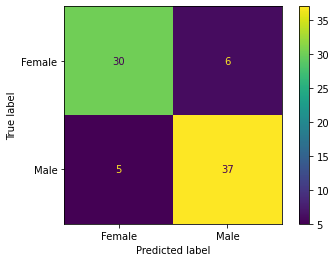

In [138]:
pipe, results, scores = canonizer(df_sizeopti_gendered)

In [118]:
pipe, results = canonizer(df_doc2vec, cross_validation=True)

              precision    recall  f1-score   support

      Female       0.76      0.68      0.71        74
        Male       0.76      0.82      0.79        90

    accuracy                           0.76       164
   macro avg       0.76      0.75      0.75       164
weighted avg       0.76      0.76      0.75       164

              precision    recall  f1-score   support

      Female       0.76      0.74      0.75        73
        Male       0.79      0.81      0.80        90

    accuracy                           0.78       163
   macro avg       0.78      0.78      0.78       163
weighted avg       0.78      0.78      0.78       163

              precision    recall  f1-score   support

      Female       0.84      0.79      0.82        73
        Male       0.84      0.88      0.86        90

    accuracy                           0.84       163
   macro avg       0.84      0.84      0.84       163
weighted avg       0.84      0.84      0.84       163

              preci

In [119]:
sum(results)/len(results)

0.792937303606165

In [113]:
sum(results)/len(results)

0.7892563220110729

In [140]:
df_doc2vec_all_corpora = pd.read_csv(r'data_all_corpora_doc2vec.csv')

In [141]:
df_doc2vec_all_corpora.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_doc2vec_all_corpora.set_index("index", inplace = True)

In [142]:
predictions = pipe.predict(df_doc2vec_all_corpora)

In [145]:
len(predictions)

27586

In [147]:
list_PER = df_doc2vec_all_corpora.index

In [148]:
df_PER_gender = pd.DataFrame(list(zip(list_PER, predictions)), columns=['character', "gender"])

In [152]:
df_PER_gender.to_csv(r'results/df_PER_gender.csv', index = False)

In [153]:
df_PER_gender

,character,gender
0,Glady-Alberic_Male-et-femelle_<Georges-839>,Female
1,Glady-Alberic_Male-et-femelle_<Georges-912>,Female
2,Glady-Alberic_Male-et-femelle_<une maîtresse-1...,Female
3,Glady-Alberic_Male-et-femelle_<un tout petit b...,Male
4,Glady-Alberic_Male-et-femelle_<Georges-417>,Female
...,...,...
27581,Boisgobey-Fortune-du_Le-crime-de-l-Opera_<M . ...,Male
27582,Boisgobey-Fortune-du_Le-crime-de-l-Opera_<votr...,Male
27583,Boisgobey-Fortune-du_Le-crime-de-l-Opera_<du c...,Male
27584,Boisgobey-Fortune-du_Le-crime-de-l-Opera_<la c...,Female


Original dataset shape Counter({'Male': 366, 'Female': 332})
              precision    recall  f1-score    support
Female         0.857143  0.833333  0.845070  36.000000
Male           0.860465  0.880952  0.870588  42.000000
accuracy       0.858974  0.858974  0.858974   0.858974
macro avg      0.858804  0.857143  0.857829  78.000000
weighted avg   0.858932  0.858974  0.858811  78.000000


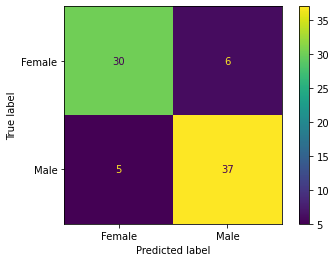

In [154]:
pipe, results, scores = canonizer(df_sizeopti_gendered)

In [155]:
results

,metadata,proba male,proba female,prediction,accord
index,,,,,
Martin-du-Gard-Roger_Les-Thibault_<L' abbé Vécard-916>,Male,0.038689,0.961311,Male,True
Lemonnier-Camille_L-homme-en-amour_<l' enfant-1077>,Male,0.961297,0.038703,Female,False
Flaubert-Gustave_Bouvard-et-Pecuchet_<Bouvard-94>,Male,0.018119,0.981881,Male,True
Melois-Clementine_Dehors-la-tempete_<moi-957>,Female,0.231345,0.768655,Male,False
Zevaco-Michel_La-Marquise-de-Pompadour_<du roi-5216>,Male,0.481483,0.518517,Male,True
...,...,...,...,...,...
Yourcenar-Marguerite_L-Oeuvre-Au-Noir_<Z�non-7139>,Male,0.048892,0.951108,Male,True
Zola-Emile_Au-bonheur-des-dames_<mon-6066>,Female,0.932703,0.067297,Female,True
Sarraute-Nathalie_Enfance_<mon �cole-1560>,Female,0.929108,0.070892,Female,True


In [160]:
df_PER_gender = pd.read_csv(r'results/df_PER_gender_dated.csv')

In [161]:
df_PER_gender.drop(["Unnamed: 0"], axis=1, inplace=True)

In [189]:
def retrieve_list_date(df_PER_gender, list_PER):
    list_gender = []
    for per in list_PER:
        if per in list(df_PER_gender.character):
            row = df_PER_gender.loc[(df_PER_gender['character']==per)]
            list_gender.append(int(row['date'].values[0]))
            
    return list_gender

In [191]:
list_gender = retrieve_list_date(df_PER_gender, list(results.index))

In [195]:
len(list(results.index))

78

In [192]:
len(list_gender)

72

In [193]:
results['gender']=list_gender

ValueError: Length of values (72) does not match length of index (78)

In [196]:
9966+17562

27528